# Intraprediction Project



## ENCODER DECODER



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
import random
import sys
import os
from optparse import OptionParser
import numpy as np
from torch import optim
from PIL import Image
from torch.autograd import Function, Variable
import matplotlib.pyplot as plt
import matplotlib 
import math
from torchvision import transforms
from torch.utils.data import Dataset
import cv2
import glob
import pickle
from tqdm import tqdm
%matplotlib inline

### [ TODO 1 ] First define following layers to be used later
- **Conv2d + BatchNorm2d + ReLu ** as **single conv2d layer** ,
- **Maxpool2d + single conv2d layer ** as **down layer**,
- **Upsample + single conv2d layer ** as **up layer** ,
-  **Conv2d ** as **outconv layer** 

You can check out the documentation in this link to understand how to use the methods called in the provided template:

 https://pytorch.org/docs/stable/nn.html
 
  ![single_conv](single_conv_layer.png)
  ![down_layer](down_layer.png)
  ![up_layer](Up_layer.png)
  ![outconv_layer](outconv_layer.png)
  

In [2]:
if torch.cuda.is_available():
    deviceTag = torch.device('cuda')
else:
    deviceTag = torch.device('cpu')
print(deviceTag)

cuda


In [3]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Function


class LowerBound(Function):
    def forward(ctx, inputs, bound):
        b = torch.ones(inputs.size())*bound
        b = b.to(inputs.device)
        ctx.save_for_backward(inputs, b)
        return torch.max(inputs, b)
  
    def backward(ctx, grad_output):
        inputs, b = ctx.saved_tensors

        pass_through_1 = inputs >= b
        pass_through_2 = grad_output < 0

        pass_through = pass_through_1 | pass_through_2
        return pass_through.type(grad_output.dtype) * grad_output, None


class GDN(nn.Module):
    """Generalized divisive normalization layer.
    y[i] = x[i] / sqrt(beta[i] + sum_j(gamma[j, i] * x[j]))
    """
  
    def __init__(self,
                 ch,
                 device,
                 inverse=False,
                 beta_min=1e-6,
                 gamma_init=.1,
                 reparam_offset=2**-18):
        super(GDN, self).__init__()
        self.inverse = inverse
        self.beta_min = beta_min
        self.gamma_init = gamma_init
        self.reparam_offset = torch.FloatTensor([reparam_offset])

        self.build(ch, torch.device(device))
  
    def build(self, ch, device):
        self.pedestal = self.reparam_offset**2
        self.beta_bound = (self.beta_min + self.reparam_offset**2)**.5
        self.gamma_bound = self.reparam_offset
  
        # Create beta param
        beta = torch.sqrt(torch.ones(ch)+self.pedestal)
        self.beta = nn.Parameter(beta.to(device))

        # Create gamma param
        eye = torch.eye(ch)
        g = self.gamma_init*eye
        g = g + self.pedestal
        gamma = torch.sqrt(g)

        self.gamma = nn.Parameter(gamma.to(device))
        self.pedestal = self.pedestal.to(device)

    def forward(self, inputs):
        unfold = False
        if inputs.dim() == 5:
            unfold = True
            bs, ch, d, w, h = inputs.size() 
            inputs = inputs.view(bs, ch, d*w, h)

        _, ch, _, _ = inputs.size()

        # Beta bound and reparam
        beta = LowerBound()(self.beta, self.beta_bound)
        beta = beta**2 - self.pedestal 

        # Gamma bound and reparam
        gamma = LowerBound()(self.gamma, self.gamma_bound)
        gamma = gamma**2 - self.pedestal
        gamma  = gamma.view(ch, ch, 1, 1)

        # Norm pool calc
        norm_ = nn.functional.conv2d(inputs**2, gamma, beta)
        norm_ = torch.sqrt(norm_)
  
        # Apply norm
        if self.inverse:
            outputs = inputs * norm_
        else:
            outputs = inputs / norm_

        if unfold:
            outputs = outputs.view(bs, ch, d, w, h)
        return outputs

In [4]:
import torch
from torch.autograd.function import InplaceFunction, Function
import torch.nn as nn
import torch.nn.functional as F
import math


def _mean(p, dim):
    """Computes the mean over all dimensions except dim"""
    if dim is None:
        return p.mean()
    elif dim == 0:
        output_size = (p.size(0),) + (1,) * (p.dim() - 1)
        return p.contiguous().view(p.size(0), -1).mean(dim=1).view(*output_size)
    elif dim == p.dim() - 1:
        output_size = (1,) * (p.dim() - 1) + (p.size(-1),)
        return p.contiguous().view(-1, p.size(-1)).mean(dim=0).view(*output_size)
    else:
        return _mean(p.transpose(0, dim), 0).transpose(0, dim)


class UniformQuantize(InplaceFunction):

    @classmethod
    def forward(cls, ctx, input, num_bits=8, min_value=None, max_value=None,
                stochastic=False, inplace=False, enforce_true_zero=False, num_chunks=None, out_half=False):

        num_chunks = num_chunks = input.shape[
            0] if num_chunks is None else num_chunks
        if min_value is None or max_value is None:
            B = input.shape[0]
            y = input.view(B // num_chunks, -1)
        if min_value is None:
            min_value = y.min(-1)[0].mean(-1)  # C
            #min_value = float(input.view(input.size(0), -1).min(-1)[0].mean())
        if max_value is None:
            #max_value = float(input.view(input.size(0), -1).max(-1)[0].mean())
            max_value = y.max(-1)[0].mean(-1)  # C
        ctx.inplace = inplace
        ctx.num_bits = num_bits
        ctx.min_value = min_value
        ctx.max_value = max_value
        ctx.stochastic = stochastic

        if ctx.inplace:
            ctx.mark_dirty(input)
            output = input
        else:
            output = input.clone()

        qmin = 0.
        qmax = 2.**num_bits - 1.
        #import pdb; pdb.set_trace()
        scale = (max_value - min_value) / (qmax - qmin)

        scale = max(scale, 1e-8)

        if enforce_true_zero:
            initial_zero_point = qmin - min_value / scale
            zero_point = 0.
            # make zero exactly represented
            if initial_zero_point < qmin:
                zero_point = qmin
            elif initial_zero_point > qmax:
                zero_point = qmax
            else:
                zero_point = initial_zero_point
            zero_point = int(zero_point)
            output.div_(scale).add_(zero_point)
        else:
            output.add_(-min_value).div_(scale).add_(qmin)

        if ctx.stochastic:
            noise = output.new(output.shape).uniform_(-0.5, 0.5)
            output.add_(noise)
        output.clamp_(qmin, qmax).round_()  # quantize

        if enforce_true_zero:
            output.add_(-zero_point).mul_(scale)  # dequantize
        else:
            output.add_(-qmin).mul_(scale).add_(min_value)  # dequantize
        if out_half and num_bits <= 16:
            output = output.half()
        return output

    @staticmethod
    def backward(ctx, grad_output):
        # straight-through estimator
        grad_input = grad_output
        return grad_input, None, None, None, None, None, None


class UniformQuantizeGrad(InplaceFunction):

    @classmethod
    def forward(cls, ctx, input, num_bits=8, min_value=None, max_value=None, stochastic=True, inplace=False):
        ctx.inplace = inplace
        ctx.num_bits = num_bits
        ctx.min_value = min_value
        ctx.max_value = max_value
        ctx.stochastic = stochastic
        return input

    @staticmethod
    def backward(ctx, grad_output):
        if ctx.min_value is None:
            min_value = float(grad_output.min())
            # min_value = float(grad_output.view(
            # grad_output.size(0), -1).min(-1)[0].mean())
        else:
            min_value = ctx.min_value
        if ctx.max_value is None:
            max_value = float(grad_output.max())
            # max_value = float(grad_output.view(
            # grad_output.size(0), -1).max(-1)[0].mean())
        else:
            max_value = ctx.max_value
        grad_input = UniformQuantize().apply(grad_output, ctx.num_bits,
                                             min_value, max_value, ctx.stochastic, ctx.inplace)
        return grad_input, None, None, None, None, None


def conv2d_biprec(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1, num_bits_grad=None):
    out1 = F.conv2d(input.detach(), weight, bias,
                    stride, padding, dilation, groups)
    out2 = F.conv2d(input, weight.detach(), bias.detach() if bias is not None else None,
                    stride, padding, dilation, groups)
    out2 = quantize_grad(out2, num_bits=num_bits_grad)
    return out1 + out2 - out1.detach()


def linear_biprec(input, weight, bias=None, num_bits_grad=None):
    out1 = F.linear(input.detach(), weight, bias)
    out2 = F.linear(input, weight.detach(), bias.detach()
                    if bias is not None else None)
    out2 = quantize_grad(out2, num_bits=num_bits_grad)
    return out1 + out2 - out1.detach()


def quantize(x, num_bits=8, min_value=None, max_value=None, num_chunks=None, stochastic=False, inplace=False):
    return UniformQuantize().apply(x, num_bits, min_value, max_value, num_chunks, stochastic, inplace)


def quantize_grad(x, num_bits=8, min_value=None, max_value=None, stochastic=True, inplace=False):
    return UniformQuantizeGrad().apply(x, num_bits, min_value, max_value, stochastic, inplace)


class QuantMeasure(nn.Module):
    """docstring for QuantMeasure."""

    def __init__(self, num_bits=8, momentum=0.1):
        super(QuantMeasure, self).__init__()
        self.register_buffer('running_min', torch.zeros(1))
        self.register_buffer('running_max', torch.zeros(1))
        self.momentum = momentum
        self.num_bits = num_bits

    def forward(self, input):
        if self.training:
            min_value = input.detach().view(
                input.size(0), -1).min(-1)[0].mean()
            max_value = input.detach().view(
                input.size(0), -1).max(-1)[0].mean()
            self.running_min.mul_(self.momentum).add_(
                min_value * (1 - self.momentum))
            self.running_max.mul_(self.momentum).add_(
                max_value * (1 - self.momentum))
        else:
            min_value = self.running_min
            max_value = self.running_max
        return quantize(input, self.num_bits, min_value=float(min_value), max_value=float(max_value), num_chunks=16)


class QConv2d(nn.Conv2d):
    """docstring for QConv2d."""

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, bias=True, num_bits=8, num_bits_weight=None, num_bits_grad=None, biprecision=False):
        super(QConv2d, self).__init__(in_channels, out_channels, kernel_size,
                                      stride, padding, dilation, groups, bias)
        self.num_bits = num_bits
        self.num_bits_weight = num_bits_weight or num_bits
        self.num_bits_grad = num_bits_grad
        self.quantize_input = QuantMeasure(self.num_bits)
        self.biprecision = biprecision

    def forward(self, input):
        qinput = self.quantize_input(input)
        qweight = quantize(self.weight, num_bits=self.num_bits_weight,
                           min_value=float(self.weight.min()),
                           max_value=float(self.weight.max()))
        if self.bias is not None:
            qbias = quantize(self.bias, num_bits=self.num_bits_weight)
        else:
            qbias = None
        if not self.biprecision or self.num_bits_grad is None:
            output = F.conv2d(qinput, qweight, qbias, self.stride,
                              self.padding, self.dilation, self.groups)
            if self.num_bits_grad is not None:
                output = quantize_grad(output, num_bits=self.num_bits_grad)
        else:
            output = conv2d_biprec(qinput, qweight, qbias, self.stride,
                                   self.padding, self.dilation, self.groups, num_bits_grad=self.num_bits_grad)

        return output


class QLinear(nn.Linear):
    """docstring for QConv2d."""

    def __init__(self, in_features, out_features, bias=True, num_bits=8, num_bits_weight=None, num_bits_grad=None, biprecision=False):
        super(QLinear, self).__init__(in_features, out_features, bias)
        self.num_bits = num_bits
        self.num_bits_weight = num_bits_weight or num_bits
        self.num_bits_grad = num_bits_grad
        self.biprecision = biprecision
        self.quantize_input = QuantMeasure(self.num_bits)

    def forward(self, input):
        qinput = self.quantize_input(input)
        qweight = quantize(self.weight, num_bits=self.num_bits_weight,
                           min_value=float(self.weight.min()),
                           max_value=float(self.weight.max()))
        if self.bias is not None:
            qbias = quantize(self.bias, num_bits=self.num_bits_weight)
        else:
            qbias = None

        if not self.biprecision or self.num_bits_grad is None:
            output = F.linear(qinput, qweight, qbias)
            if self.num_bits_grad is not None:
                output = quantize_grad(output, num_bits=self.num_bits_grad)
        else:
            output = linear_biprec(qinput, qweight, qbias, self.num_bits_grad)
        return output

In [5]:
################################################ [TODO] ###################################################
# DEFINE SINGLE_CONV CLASS
class single_conv(nn.Module):
    '''(conv => BN => ReLU) '''
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_ch), # Channels in
            nn.Conv2d(in_ch,out_ch,3), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )

    def forward(self, x):
        x = self.conv(x)
        return x
    
class single_convPad(nn.Module):
    '''(conv => BN => ReLU) '''
    def __init__(self, in_ch, out_ch):
        super(single_convPad, self).__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_ch), # Channels in
            nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(in_ch,out_ch,3), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )

    def forward(self, x):
        x = self.conv(x)
        return x

In [6]:
class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()       
        self.up = nn.Sequential(
            nn.BatchNorm2d(in_ch), # Channels in
            nn.ConvTranspose2d(in_ch,in_ch,kernel_size=3, stride=2), #(channel in, channel out, filter)
        ) 
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_ch), # Channels in
            #nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(in_ch,out_ch,2), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )
    def forward(self, x):
        x = self.up(x)
        #x = nn.functional.upsample(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.conv(x)
        return x
    
class upScale(nn.Module):
    def __init__(self, in_ch, out_ch, scale):
        super(upScale, self).__init__()
        self.up = nn.Sequential(
            nn.BatchNorm2d(in_ch), # Channels in
            nn.ConvTranspose2d(in_ch,in_ch,kernel_size=scale, stride=scale), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )
        self.inc = nn.Sequential(
            nn.BatchNorm2d(out_ch), # Channels in
            nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(out_ch,out_ch,3), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )
    def forward(self, x):
        x = self.up(x)
        x = self.inc(x)
        return x

In [7]:
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.down = nn.Sequential(
            nn.BatchNorm2d(in_ch), # Channels in
            nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(in_ch,out_ch,4,stride=2), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )
        self.conv = single_conv(out_ch, out_ch) # use previously defined single_cov
    def forward(self, x):
        x = self.down(x)
        x = self.conv(x)
        return x
    
class downPad(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(downPad, self).__init__()
        self.down = nn.Sequential(
            nn.BatchNorm2d(in_ch), # Channels in
            nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(in_ch,out_ch,4,stride=2), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )
        self.inc = nn.Sequential(
            nn.BatchNorm2d(out_ch), # Channels in
            nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(out_ch,out_ch,3), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )

    def forward(self, x):
        x = self.down(x)
        x = self.inc(x)
        return x

class downR(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(downR, self).__init__()
        self.down = nn.Sequential(
            #nn.BatchNorm2d(in_ch), # Channels in
            nn.ReplicationPad2d((1,0,1,0)),
            nn.Conv2d(in_ch,out_ch,3,stride=2), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )

    def forward(self, x):
        x = self.down(x)
        return x
    
class downScale(nn.Module):
    def __init__(self, in_ch, out_ch, scale):
        super(downScale, self).__init__()
        self.down = nn.Sequential(
            nn.BatchNorm2d(in_ch), # Channels in
            nn.Conv2d(in_ch,out_ch,scale,stride=scale), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )
        self.inc = nn.Sequential(
            nn.BatchNorm2d(out_ch), # Channels in
            nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(out_ch,out_ch,3), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )
    def forward(self, x):
        x = self.down(x)
        return x

In [8]:
class RB(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(RB, self).__init__()
        self.conv = nn.Sequential(
            nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(in_ch,in_ch,3), #(channel in, channel out, filter)
        ).to(deviceTag);
        self.conv2 = nn.Sequential(
            nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(in_ch,in_ch,3), #(channel in, channel out, filter)        )
        ).to(deviceTag);
    def forward(self, x):
        xorig = x
        x = self.conv(x)
        x = torch.tanh(x)
        x = self.conv2(x)
        x = x+xorig
        return x
    
class RNAB(nn.Module):
    def __init__(self, in_ch):
        super(RNAB, self).__init__()
        self.RB1 = RB(in_ch,in_ch)
        self.RB2 = RB(in_ch,in_ch) 
        self.RB3 = RB(in_ch,in_ch) 
        self.down = downPad(in_ch,in_ch)
        self.RB4 = RB(in_ch,in_ch) 
        self.RB5 = RB(in_ch,in_ch) 
        self.up =  up(in_ch,in_ch) 
        self.RB6 = RB(in_ch,in_ch) 
        self.conv = nn.Sequential(
            nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(in_ch,in_ch,3), #(channel in, channel out, filter)
            nn.Sigmoid()
        )
        
    def forward(self, x):
        xorig = x
        xmain = self.RB1(x)
        xmain = self.RB2(xmain)
        xbranch = self.RB3(x)
        xbranch = self.down(xbranch)
        xbranch = self.RB4(xbranch)
        xbranch = self.RB5(xbranch) 
        xbranch = self.up(xbranch)
        xbranch = self.RB6(xbranch)
        xbranch = self.conv(xbranch)
        x = xmain*xbranch
        x = x + xorig
        return x
    

In [9]:
class RDB(nn.Module):
    def __init__(self, in_ch):
        super(RDB, self).__init__()
        self.conv1 = nn.Sequential(
            nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(in_ch,in_ch,3), #(channel in, channel out, filter)
            nn.BatchNorm2d(in_ch), # Channels in
            nn.PReLU()
        ).to(deviceTag);
        self.conv2 = nn.Sequential(
            nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(in_ch*2,in_ch,3), #(channel in, channel out, filter)
            nn.BatchNorm2d(in_ch), # Channels in
            nn.PReLU()
        ).to(deviceTag);
        self.conv3 = nn.Sequential(
            nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(in_ch*3,in_ch,3), #(channel in, channel out, filter)
            nn.BatchNorm2d(in_ch), # Channels in
            nn.PReLU()
        ).to(deviceTag);
        self.sum =  nn.Conv2d(in_ch*4,in_ch,1) #(channel in, channel out, filter)        )
    def forward(self, x):
        xorig = x
        x1 = self.conv1(x)
        x2 = torch.cat([x1, x], dim=1)
        x2 = self.conv2(x2)
        x3 = torch.cat([x2, x1, x], dim=1)
        x3 = self.conv3(x3)
        x4 = torch.cat([x3, x2, x1, x], dim=1)
        x4 = self.sum(x4)
        x = xorig +x4
        return x
    
class GRDB(nn.Module):
    def __init__(self, in_ch):
        super(GRDB, self).__init__()
        self.RDB1 = RDB(in_ch)
        self.RDB2 = RDB(in_ch)
        self.RDB3 = RDB(in_ch)
        self.RDB4 = RDB(in_ch)
        self.sum =  nn.Conv2d(in_ch*4,in_ch,1) #(channel in, channel out, filter)        )
    def forward(self, x):
        x1 = self.RDB1(x)
        x2 = self.RDB2(x1)
        x3 = self.RDB3(x2)
        x4 = self.RDB3(x3)
        xtotal = torch.cat([x1, x2,x3,x4], dim=1)
        xtotal = self.sum(xtotal)
        x = x+xtotal
        return x    

In [27]:
################################################ [TODO] ###################################################
# Build your network with predefined classes: single_conv, up, down, outconv
# The number of input and output channels should follow the U-Net Structure shown above.
import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, n_channels):
        super(UNet, self).__init__()
        self.pad = nn.ReplicationPad2d((1,1,1,1))
        self.inc = single_conv(n_channels, 64)
        self.down1 = downPad(64,256)
        self.down2 = downPad(256,512)
        self.down3 = single_conv(512, 512) # conv2d +  batchnorm + relu
        self.comp = nn.Sequential(
            nn.Conv2d(512,8,1), #(channel in, channel out, filter)
            #nn.Tanh(), #Channel in
        )
        self.up1 = up(8,512)
        self.up2 = up(512,256)
        self.up3 = up(256,64)
        self.inc4 = nn.Sequential(
            nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(64,3,3), #(channel in, channel out, filter)
        #    #nn.Hardtanh(), #Channel in
        )
        self.GDN1 = GDN(ch=256, device='cuda', inverse=False)
        self.GDN2 = GDN(ch=512, device='cuda', inverse=False)
        self.GDN3 = GDN(ch=512, device='cuda', inverse=False)
        self.iGDN1 = GDN(ch=512, device='cuda', inverse=True)
        self.iGDN2 = GDN(ch=256, device='cuda', inverse=True)
        #DENOISING
        self.conv= nn.Sequential(
            nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(3,64,3), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )
        self.down = downPad(64,128)
        self.GRDB1 = GRDB(128)
        self.GRDB2 = GRDB(128)
        self.GRDB3 = GRDB(128)
        self.GRDB4 = GRDB(128)
        self.up = up(128,64)
        self.conv2 = nn.Sequential(
            #nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(64,3,1), #(channel in, channel out, filter)
        )
    def forward(self, x):
        #ENCODE
        shape = x.shape
        x = x.to(deviceTag)
        x20 = x.clone()
        x16 = x[:,:,4:20,4:20]
        x20[:,:,4:20,4:20] = torch.zeros(shape[0],shape[1],16,16)
        x = self.pad(x16)
        x = self.inc(x)
        x = self.down1(x) #20x20 ->10x10 ->8x8
        x = self.GDN1(x)
        x = self.down2(x) #8x8 ->10x10 ->4x4
        x = self.GDN2(x)
        x = self.down3(x) 
        x = self.GDN3(x)
        x = self.comp(x)
        x = torch.tanh(7*x)
        x = quantize(x, num_bits=1, min_value=-1, max_value=1, inplace=False)
        x = self.up1(x) #6x6
        x = self.iGDN1(x)
        x = self.up2(x) #8x8
        x = self.iGDN2(x)
        x = self.up3(x) #16x16
        x = self.inc4(x) #
        x16 = F.hardtanh(x, min_val = -128/255, max_val = 127/255)
        x16_2 = F.pad(x16, (4,0,4,0))
        x20 = x16_2+x20
        xmain = self.conv(x20)#20x20x64
        xmain = self.down(xmain)
        xmain = self.GRDB1(xmain)
        xmain = self.GRDB2(xmain)
        xmain = self.GRDB3(xmain)
        xmain = self.GRDB4(xmain)
        xmain = self.up(xmain)
        xmain = self.conv2(xmain)
        x = xmain+x20
        x20 = F.hardtanh(x, min_val=-128/255, max_val=127/255)
        return x16, x20
    
    def load_my_state_dict(self, state_dict):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                 continue
            #if isinstance(param, self.Parameter):
            else:
                # backwards compatibility for serialized parameters
                param = param.data
            own_state[name].copy_(param)

In [52]:
################################################ [TODO] ###################################################
# Build your network with predefined classes: single_conv, up, down, outconv
# The number of input and output channels should follow the U-Net Structure shown above.
import torch.nn.functional as F
class UNet1(nn.Module):
    def __init__(self, n_channels):
        super(UNet1, self).__init__()
        self.pad = nn.ReplicationPad2d((1,1,1,1))
        self.inc = single_conv(n_channels, 64)
        self.down1 = downPad(64,256)
        self.down2 = downPad(256,512)
        self.down3 = single_conv(512, 512) # conv2d +  batchnorm + relu
        self.comp = nn.Sequential(
            nn.Conv2d(512,8,1), #(channel in, channel out, filter)
            #nn.Tanh(), #Channel in
        )
        self.up1 = up(8,512)
        self.up2 = up(512,256)
        self.up3 = up(256,64)
        self.inc4 = nn.Sequential(
        #    nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(64,3,1), #(channel in, channel out, filter)
        #    #nn.Hardtanh(), #Channel in
        )
        self.GDN1 = GDN(ch=256, device='cuda', inverse=False)
        self.GDN2 = GDN(ch=512, device='cuda', inverse=False)
        self.GDN3 = GDN(ch=512, device='cuda', inverse=False)
        self.iGDN1 = GDN(ch=512, device='cuda', inverse=True)
        self.iGDN2 = GDN(ch=256, device='cuda', inverse=True)
        self.RB1 = RB(512,512)
        self.RB2 = RB(512,512)
        self.RB3 = RB(512,512)
        self.RB4 = RB(256,256)
        self.RB5 = RB(256,256)
        self.RB6 = RB(256,256)
        self.RB7 = RB(64,64)
        self.RB8 = RB(64,64)
        self.RB9 = RB(64,64)
        #DENOISING
        self.conv= nn.Sequential(
            nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(3,64,3), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )
        self.down = downPad(64,128)
        self.GRDB1 = GRDB(128)
        self.GRDB2 = GRDB(128)
        self.GRDB3 = GRDB(128)
        self.GRDB4 = GRDB(128)
        self.up = up(128,64)
        self.conv2 = nn.Sequential(
            nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(64,3,3), #(channel in, channel out, filter)
        )
    def forward(self, x):
        #ENCODE
        shape = x.shape
        x = x.to(deviceTag)
        x20 = x.clone()
        x16 = x[:,:,4:20,4:20]
        x20[:,:,4:20,4:20] = torch.zeros(shape[0],shape[1],16,16)
        x = self.pad(x16)
        x = self.inc(x)
        x = self.down1(x) #20x20 ->10x10 ->8x8
        x = self.GDN1(x)
        x = self.down2(x) #8x8 ->10x10 ->4x4
        x = self.GDN2(x)
        x = self.down3(x) 
        x = self.GDN3(x)
        x = self.comp(x)
        x = torch.tanh(7*x)
        x = quantize(x, num_bits=1, min_value=-1, max_value=1, inplace=False)
        x = self.up1(x) #6x6
        x2 = self.RB1(x)
        x2 = self.RB2(x2)
        x2 = self.RB3(x2)
        x = x + x2
        x = self.iGDN1(x)
        x = self.up2(x) #8x8
        x2 = self.RB4(x)
        x2 = self.RB5(x2)
        x2 = self.RB6(x2)
        x = x + x2
        x = self.iGDN2(x)
        x = self.up3(x) #16x16
        x2 = self.RB7(x)
        x2 = self.RB8(x2)
        x2 = self.RB9(x2)
        x = x + x2
        x = self.inc4(x) #
        x16 = F.hardtanh(x, min_val = -128/255, max_val = 127/255)
        x16_2 = F.pad(x16, (4,0,4,0))
        x20 = x16_2+x20
        xmain = self.conv(x20)#20x20x64
        xmain = self.down(xmain)
        xmain = self.GRDB1(xmain)
        xmain = self.GRDB2(xmain)
        xmain = self.GRDB3(xmain)
        xmain = self.GRDB4(xmain)
        xmain = self.up(xmain)
        xmain = self.conv2(xmain)
        x = xmain+x20
        x20 = F.hardtanh(x, min_val=-128/255, max_val=127/255)
        return x16, x20
    
    def load_my_state_dict(self, state_dict):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                 continue
            #if isinstance(param, self.Parameter):
            else:
                # backwards compatibility for serialized parameters
                param = param.data
            own_state[name].copy_(param)

In [53]:
PATH = './model/2x2x8_RB3.pth' #Using grad2
#PATH = './model/Car_Seg_Epoch63.pth'
net = UNet1(3).to(deviceTag);
net.load_my_state_dict(torch.load(PATH,deviceTag))


### [ TODO 2 ] Define evaulation function:
Based on what we have learnt in class, Dice coefficient is defined as 
![dice.png](dice.png)
For the case of evaluating a Dice coefficient on predicted segmentation masks, we can approximate intersection of A and B as the element-wise multiplication between the prediction and target mask, and then sum the resulting matrix.

In order to quantify the area of A union B, some researchers use the simple sum whereas other researchers prefer to use the squared sum for this calculation. You can use either way.



In [38]:
################################################ [TODO] ###################################################
# Calculate dice coefficients for batches
def grad1620(input16, target):
    p,q,r  = 0.2,0.4, 0.4
    loss16 = torch.FloatTensor(1).zero_().to(deviceTag);
    loss20 = torch.FloatTensor(1).zero_().to(deviceTag);
    Gx_target, Gy_target = grad2(target)
    Gx_in16 , Gy_in16 = grad2(input16)
    s = torch.FloatTensor(1).zero_().to(deviceTag);
    s += p*F.mse_loss(input16, target)
    s += q*F.mse_loss(Gx_in16, Gx_target)
    s += r*F.mse_loss(Gy_in16, Gy_target)
    return  s

################################################ [TODO] ###################################################
# define dice coefficient 
class MseCoeff(Function):
    """Dice coeff for one pair of input image and target image"""
    def forward(self, input, target):
        self.save_for_backward(input, target)
        ################################################ [TODO] ###################################################
        # Calculate intersection and union. 
        # You can convert the input image into a vector with input.contiguous().view(-1)
        # Then use torch.dot(A, B) to calculate the intersection.
        # Use torch.sum(A) to get the sum.
        input = input.contiguous().view(-1)
        target = target.contiguous().view(-1)
        # Calculate Mean Squared Error
        diff = input - target;
        dot =  torch.dot(diff,diff)
        dot = dot/input.numel()
        return dot

################################################ [TODO] ###################################################
# Calculate dice coefficients for batches
def mse_coeff(input, target):
    """Dice coeff for batches"""
    s = torch.FloatTensor(1).zero_().to(deviceTag)   
    # For each pair of input and target, call DiceCoeff().forward(input, target) to calculate dice coefficient
    # Then average
    MSE = MseCoeff()
    for i, (c, b) in enumerate(zip(input, target)):
        s += MSE.forward(c,b);
    s = s / (i + 1)
    return s

def grad(input):
    #satcal = input[2,:,:]
    x_right = F.pad(input, (0, 1, 0, 0))
    x_left = F.pad(input, (1, 0, 0, 0 ))
    y_up =   F.pad(input, (0, 0, 1, 0 )) 
    y_down =   F.pad(input, (0, 0, 0,1))
    dx = x_right - x_left;
    dy = y_up - y_down;
    return dx[:,:,1:15, 1:15].to(deviceTag), dy[:,:,1:15, 1:15].to(deviceTag)

def grad2(input):
    #satcal = input[2,:,:]
    x_right = F.pad(input, (0, 2, 0, 0))
    x_left = F.pad(input, (2, 0, 0, 0 ))
    x_center = F.pad(input,(1,1,0,0))
    y_up =   F.pad(input, (0, 0, 2, 0 )) 
    y_down =   F.pad(input, (0, 0, 0,2))
    y_center = F.pad(input,(0,0,1,1))
    dx = 2*x_center - x_right - x_left;
    dy = 2*y_center - y_up - y_down;
    return dx[:,2:15, 2:15]/4., dy[:,2:15, 2:15]/4

class gradLoss(nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction='mean'):
        super(gradLoss, self).__init__(size_average, reduce, reduction)

    def forward(self, input, target):
        p,q,r  = 0.2,0.4, 0.4
        input = input.to(deviceTag)
        s = torch.FloatTensor(1).zero_().to(deviceTag);
        Gx_target, Gy_target = grad2(target)
        Gx_in , Gy_in = grad2(input)
        s += p*F.mse_loss(input, target, reduction=self.reduction)
        s += q*F.mse_loss(Gx_in, Gx_target, reduction=self.reduction)
        s += r*F.mse_loss(Gy_in, Gy_target, reduction=self.reduction)
        return s



### Load images and masks

This part is to convert data into HSV form and normalize. Added this part down this.

In [39]:
validation = glob.glob('./Data/Validation/*')
train = glob.glob('./Data/Train_more/*')
test = glob.glob('./Data/Test/*')
valiDataset = []
trainDataset = []
testDataset = []
#Loads the following in a list of (3, 16,16) and (3, 20,20)
for i in range(len(validation)):
    f=open(validation[i],'rb')
    b=pickle.load(f)
    f.close()
    b = np.transpose(b, axes=[3, 2, 0, 1]) 
    valiDataset.append(b)
    
for i in range(len(test)):
    f=open(test[i],'rb')
    b=pickle.load(f)
    f.close()
    #b = np.transpose(b, axes=[3, 2, 0, 1]) 
    testDataset.append(b)

for i in range(len(train)):
    f=open(train[i],'rb')
    b=pickle.load(f)
    f.close()
    #b = np.transpose(b, axes=[3, 2, 0, 1]) 
    trainDataset.append(b)

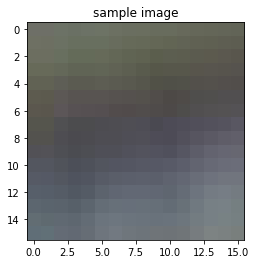

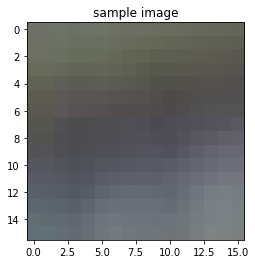

In [40]:
#### Let us display some of the images to make sure the data loading and processing is correct.
### the original size of the image is: 1280*1918, but we resize the image to 80*100 for 
### training the segmentation network
img_num = 100
a = valiDataset[1][img_num]
img2 = np.transpose(a, axes = [1,2,0])+0.5
img2 = img2.astype(np.float32)
#img2 = cv2.cvtColor(img2, cv2.COLOR_YCR_CB2BGR)
#img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.title("sample image")
plt.show()
#a = matplotlib.colors.hsv_to_rgb(a)
img = a*255+128
#img = convYCbCrtoRGB(img)
img = np.transpose(img, axes = [1,2,0])
img = img/255
plt.imshow(img)
plt.title("sample image")
plt.show()

In [41]:
print(valiDataset[1].shape)

(10000, 3, 16, 16)


### Create datasets in the format that you can later use Torch  "DataLoader" during training and define  data augmentation 

In [42]:
#### define transform classes for  data augmentation
class Flip(object):
    """
    Flip the image left or right for data augmentation, but prefer original image.
    """
    def __init__(self,ori_probability=0.60):
        self.ori_probability = ori_probability
 
    def __call__(self, sample):
        if random.uniform(0,1) < self.ori_probability:
            return sample
        else:
            img, label = sample['img'], sample['label']
            img_flip = img[:,:,::-1]
            label_flip = label[:,::-1]
            
            return {'img': img_flip, 'label': label_flip}
        
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']

        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}

In [43]:
# the dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels):   # initial logic happens like transform
        self.image = images
        self.labels = labels
        #self.transforms = transforms
    
    def __len__(self):  # return count of sample we have

        return len(self.labels)
    
    def __getitem__(self, index):
        orig = self.image[index];
        label = self.labels[index]
        sample = {'img': orig, 'label': label}
        #if transforms:
        #    sample = self.transforms(sample)            
        return sample

#train_dataset = CustomDataset(((trainDataset[1]-128)/255), trainDataset[0], transforms=transforms.Compose([Flip(),ToTensor()]))
train_dataset = CustomDataset(trainDataset[0], trainDataset[0])
val_dataset = CustomDataset(valiDataset[0], valiDataset[1])

In [44]:
print(trainDataset[0].shape)
print(trainDataset[1].shape)
print(valiDataset[0].shape)
print(valiDataset[1].shape)


(199913, 3, 20, 20)
(199913, 3, 16, 16)
(10000, 3, 20, 20)
(10000, 3, 16, 16)


### [ TODO 3 ] Start training your network

In [22]:
def convYCbCrtoRGB(image):
    #TAKES IN IMAGE FORMAT 3xNxN
    y = image[:,0,:,:]
    cB = image[:,2,:,:] - 128
    cR = image[:,1,:,:] - 128
    RGBImage = torch.zeros(image.shape)
    RGBImage[:,0,:,:]   =   1.0 * y    + 0 * cB    + 1.402 * cR
    RGBImage[:,1,:,:]   =   1.0 * y    - 0.344136 * cB - 0.714136 * cR
    RGBImage[:,2,:,:]   =   1.0 * y    + 1.772 * cB    + 0 * cR
    return RGBImage

In [23]:
# function to calculate the psnr
# input : #1- noisy image , #2- original image as reference
# OUTPUT: PSNR value
def psnrCalc(input, target):
    inputNorm = input*255+128
    targetNorm = target*255+128
    #inputNorm = convYCbCrtoRGB(inputNorm)
    #targetNorm = convYCbCrtoRGB(targetNorm)
    ##########################################    [TODO]    ##########################################
    # Write the code to find the psnr
    mse = F.mse_loss(inputNorm, targetNorm)
    if mse == 0:
        psnr = 100
    else:
        PIXEL_MAX = 255.0
        psnr = 10 * math.log10(PIXEL_MAX*PIXEL_MAX / mse)
    return psnr

################################################ [TODO] ###################################################
# This function is used to evaluate the network after each epoch of training
# Input: network and validation dataset
# Output: average dice_coeff
def eval_net(net, dataset):
    # set net mode to evaluation
    net.eval()
    tot = 0
    PSNR = 0;
    with torch.no_grad():
        for i, b in enumerate(dataset):
            img = b['img'].to(deviceTag);
            label = b['label'].to(deviceTag);
            img = img.type(torch.FloatTensor);
            label = label.type(torch.FloatTensor).to(deviceTag);
            ################################################ [TODO] ################################################### 
            # Feed in the image to get predicted image
            img_pred16, img_pred20 = net.forward(img)
            ### REMEMBER TO CHANGE THIS IF YOU WANT TO TRAIN JUST 16
            #tot += grad1620(img_pred16, label)
            img_pred20 = img_pred20[:,:,4:20,4:20]
            PSNR += psnrCalc(img_pred20, label)
            tot +=F.mse_loss(img_pred20, label)
    return tot / (i + 1), PSNR/ (i+1)

# NEURAL NETWORK RUN

In [24]:
################################################ [TODO] ###################################################
# Create a UNET object. Input channels = 3, output channels = 1
net = UNet1(3)
net = net.to(deviceTag)

Starting epoch 1/80.
0.0000 --- loss: 0.026814
0.0250 --- loss: 0.004669
0.0500 --- loss: 0.004586
0.0750 --- loss: 0.004306
0.1000 --- loss: 0.003688
0.1251 --- loss: 0.004551
0.1501 --- loss: 0.002760
0.1751 --- loss: 0.003077
0.2001 --- loss: 0.003010
0.2251 --- loss: 0.002746
0.2501 --- loss: 0.004459
0.2751 --- loss: 0.003775
0.3001 --- loss: 0.003266
0.3251 --- loss: 0.002712
0.3502 --- loss: 0.003160
0.3752 --- loss: 0.002609
0.4002 --- loss: 0.003475
0.4252 --- loss: 0.003210
0.4502 --- loss: 0.002237
0.4752 --- loss: 0.002523
0.5002 --- loss: 0.003154
0.5252 --- loss: 0.002806
0.5502 --- loss: 0.002533
0.5753 --- loss: 0.003809
0.6003 --- loss: 0.003146
0.6253 --- loss: 0.002633
0.6503 --- loss: 0.002485
0.6753 --- loss: 0.003179
0.7003 --- loss: 0.002678
0.7253 --- loss: 0.002903
0.7503 --- loss: 0.002399
0.7753 --- loss: 0.003275
0.8003 --- loss: 0.002659
0.8254 --- loss: 0.003947
0.8504 --- loss: 0.001917
0.8754 --- loss: 0.002120
0.9004 --- loss: 0.002621
0.9254 --- loss: 

0.9504 --- loss: 0.002054
0.9754 --- loss: 0.002900
Epoch finished ! Loss: 0.0023526355999156415
Validation Dice Coeff: 0.0024675335735082626
PSNR Coeff: 26.272295041644888
Checkpoint 7 saved !
Starting epoch 8/80.
0.0000 --- loss: 0.002622
0.0250 --- loss: 0.002688
0.0500 --- loss: 0.002434
0.0750 --- loss: 0.002910
0.1000 --- loss: 0.001775
0.1251 --- loss: 0.003039
0.1501 --- loss: 0.002650
0.1751 --- loss: 0.002132
0.2001 --- loss: 0.002497
0.2251 --- loss: 0.003273
0.2501 --- loss: 0.003000
0.2751 --- loss: 0.002412
0.3001 --- loss: 0.002495
0.3251 --- loss: 0.002191
0.3502 --- loss: 0.001831
0.3752 --- loss: 0.002354
0.4002 --- loss: 0.001218
0.4252 --- loss: 0.002375
0.4502 --- loss: 0.001471
0.4752 --- loss: 0.002031
0.5002 --- loss: 0.003125
0.5252 --- loss: 0.002472
0.5502 --- loss: 0.002547
0.5753 --- loss: 0.002577
0.6003 --- loss: 0.001791
0.6253 --- loss: 0.002319
0.6503 --- loss: 0.001848
0.6753 --- loss: 0.001785
0.7003 --- loss: 0.002578
0.7253 --- loss: 0.002147
0.750

0.7503 --- loss: 0.001983
0.7753 --- loss: 0.001883
0.8003 --- loss: 0.002223
0.8254 --- loss: 0.001681
0.8504 --- loss: 0.001535
0.8754 --- loss: 0.001791
0.9004 --- loss: 0.001596
0.9254 --- loss: 0.002203
0.9504 --- loss: 0.002342
0.9754 --- loss: 0.001501
Epoch finished ! Loss: 0.002167020979495915
Validation Dice Coeff: 0.002326622139662504
PSNR Coeff: 26.51472395835387
Checkpoint 14 saved !
Starting epoch 15/80.
0.0000 --- loss: 0.002320
0.0250 --- loss: 0.002556
0.0500 --- loss: 0.002053
0.0750 --- loss: 0.001493
0.1000 --- loss: 0.002122
0.1251 --- loss: 0.001905
0.1501 --- loss: 0.002231
0.1751 --- loss: 0.002383
0.2001 --- loss: 0.001788
0.2251 --- loss: 0.001510
0.2501 --- loss: 0.001700
0.2751 --- loss: 0.002087
0.3001 --- loss: 0.002007
0.3251 --- loss: 0.001905
0.3502 --- loss: 0.002489
0.3752 --- loss: 0.002833
0.4002 --- loss: 0.002414
0.4252 --- loss: 0.001779
0.4502 --- loss: 0.002820
0.4752 --- loss: 0.002060
0.5002 --- loss: 0.002014
0.5252 --- loss: 0.002362
0.5502

0.5252 --- loss: 0.002793
0.5502 --- loss: 0.002181
0.5753 --- loss: 0.002438
0.6003 --- loss: 0.002820
0.6253 --- loss: 0.002129
0.6503 --- loss: 0.001557
0.6753 --- loss: 0.002741
0.7003 --- loss: 0.001245
0.7253 --- loss: 0.002253
0.7503 --- loss: 0.002405
0.7753 --- loss: 0.001568
0.8003 --- loss: 0.002784
0.8254 --- loss: 0.001829
0.8504 --- loss: 0.001365
0.8754 --- loss: 0.002154
0.9004 --- loss: 0.003113
0.9254 --- loss: 0.001469
0.9504 --- loss: 0.003398
0.9754 --- loss: 0.002117
Epoch finished ! Loss: 0.0020367491137537556
Validation Dice Coeff: 0.0023021004162728786
PSNR Coeff: 26.64105818724267
Checkpoint 21 saved !
Starting epoch 22/80.
0.0000 --- loss: 0.001546
0.0250 --- loss: 0.002155
0.0500 --- loss: 0.002490
0.0750 --- loss: 0.001510
0.1000 --- loss: 0.002967
0.1251 --- loss: 0.002407
0.1501 --- loss: 0.002338
0.1751 --- loss: 0.002421
0.2001 --- loss: 0.001941
0.2251 --- loss: 0.001992
0.2501 --- loss: 0.002022
0.2751 --- loss: 0.002935
0.3001 --- loss: 0.001674
0.32

0.3001 --- loss: 0.002228
0.3251 --- loss: 0.001458
0.3502 --- loss: 0.001148
0.3752 --- loss: 0.001955
0.4002 --- loss: 0.002240
0.4252 --- loss: 0.002730
0.4502 --- loss: 0.001620
0.4752 --- loss: 0.002813
0.5002 --- loss: 0.001130
0.5252 --- loss: 0.002116
0.5502 --- loss: 0.001891
0.5753 --- loss: 0.002301
0.6003 --- loss: 0.001819
0.6253 --- loss: 0.001608
0.6503 --- loss: 0.002415
0.6753 --- loss: 0.001264
0.7003 --- loss: 0.001955
0.7253 --- loss: 0.001714
0.7503 --- loss: 0.002458
0.7753 --- loss: 0.001528
0.8003 --- loss: 0.002426
0.8254 --- loss: 0.002290
0.8504 --- loss: 0.001310
0.8754 --- loss: 0.001820
0.9004 --- loss: 0.001193
0.9254 --- loss: 0.003209
0.9504 --- loss: 0.002239
0.9754 --- loss: 0.002361
Epoch finished ! Loss: 0.001911510790707781
Validation Dice Coeff: 0.0023025686386972666
PSNR Coeff: 26.604594257449353
Checkpoint 28 saved !
Starting epoch 29/80.
0.0000 --- loss: 0.002285
0.0250 --- loss: 0.001967
0.0500 --- loss: 0.001901
0.0750 --- loss: 0.003030
0.10

0.0750 --- loss: 0.001297
0.1000 --- loss: 0.001561
0.1251 --- loss: 0.001806
0.1501 --- loss: 0.001449
0.1751 --- loss: 0.001840
0.2001 --- loss: 0.001981
0.2251 --- loss: 0.001491
0.2501 --- loss: 0.001805
0.2751 --- loss: 0.001237
0.3001 --- loss: 0.001768
0.3251 --- loss: 0.001009
0.3502 --- loss: 0.001196
0.3752 --- loss: 0.002029
0.4002 --- loss: 0.000848
0.4252 --- loss: 0.000955
0.4502 --- loss: 0.001345
0.4752 --- loss: 0.002032
0.5002 --- loss: 0.000905
0.5252 --- loss: 0.001893
0.5502 --- loss: 0.001980
0.5753 --- loss: 0.001593
0.6003 --- loss: 0.001673
0.6253 --- loss: 0.002236
0.6503 --- loss: 0.002123
0.6753 --- loss: 0.001345
0.7003 --- loss: 0.001354
0.7253 --- loss: 0.001608
0.7503 --- loss: 0.001740
0.7753 --- loss: 0.001906
0.8003 --- loss: 0.001496
0.8254 --- loss: 0.001307
0.8504 --- loss: 0.001723
0.8754 --- loss: 0.001429
0.9004 --- loss: 0.001985
0.9254 --- loss: 0.001433
0.9504 --- loss: 0.001484
0.9754 --- loss: 0.001420
Epoch finished ! Loss: 0.0017051001179

Validation Dice Coeff: 0.0022187083959579468
PSNR Coeff: 26.76548265344257
Checkpoint 41 saved !
Starting epoch 42/80.
0.0000 --- loss: 0.001134
0.0250 --- loss: 0.001733
0.0500 --- loss: 0.001593
0.0750 --- loss: 0.001612
0.1000 --- loss: 0.001838
0.1251 --- loss: 0.001540
0.1501 --- loss: 0.001712
0.1751 --- loss: 0.001913
0.2001 --- loss: 0.001392
0.2251 --- loss: 0.001459
0.2501 --- loss: 0.001365
0.2751 --- loss: 0.001889
0.3001 --- loss: 0.001057
0.3251 --- loss: 0.001459
0.3502 --- loss: 0.001474
0.3752 --- loss: 0.001185
0.4002 --- loss: 0.001232
0.4252 --- loss: 0.001483
0.4502 --- loss: 0.001800
0.4752 --- loss: 0.001422
0.5002 --- loss: 0.001691
0.5252 --- loss: 0.001440
0.5502 --- loss: 0.001925
0.5753 --- loss: 0.002165
0.6003 --- loss: 0.001791
0.6253 --- loss: 0.001743
0.6503 --- loss: 0.001394
0.6753 --- loss: 0.000994
0.7003 --- loss: 0.002157
0.7253 --- loss: 0.001901
0.7503 --- loss: 0.001515
0.7753 --- loss: 0.002127
0.8003 --- loss: 0.001595
0.8254 --- loss: 0.0012

0.8254 --- loss: 0.002234
0.8504 --- loss: 0.001714
0.8754 --- loss: 0.001102
0.9004 --- loss: 0.001400
0.9254 --- loss: 0.001453
0.9504 --- loss: 0.001666
0.9754 --- loss: 0.001830
Epoch finished ! Loss: 0.0016355628624156382
Validation Dice Coeff: 0.002222300274297595
PSNR Coeff: 26.790246480416894
Checkpoint 48 saved !
Starting epoch 49/80.
0.0000 --- loss: 0.001908
0.0250 --- loss: 0.002239
0.0500 --- loss: 0.001847
0.0750 --- loss: 0.002320
0.1000 --- loss: 0.001749
0.1251 --- loss: 0.002050
0.1501 --- loss: 0.001718
0.1751 --- loss: 0.001820
0.2001 --- loss: 0.001279
0.2251 --- loss: 0.001817
0.2501 --- loss: 0.002082
0.2751 --- loss: 0.000841
0.3001 --- loss: 0.001482
0.3251 --- loss: 0.002007
0.3502 --- loss: 0.002072
0.3752 --- loss: 0.001430
0.4002 --- loss: 0.002195
0.4252 --- loss: 0.002237
0.4502 --- loss: 0.001634
0.4752 --- loss: 0.001253
0.5002 --- loss: 0.001289
0.5252 --- loss: 0.001357
0.5502 --- loss: 0.001415
0.5753 --- loss: 0.001407
0.6003 --- loss: 0.001670
0.62

0.6003 --- loss: 0.001628
0.6253 --- loss: 0.001369
0.6503 --- loss: 0.001364
0.6753 --- loss: 0.001353
0.7003 --- loss: 0.001665
0.7253 --- loss: 0.001586
0.7503 --- loss: 0.001398
0.7753 --- loss: 0.001778
0.8003 --- loss: 0.001236
0.8254 --- loss: 0.001991
0.8504 --- loss: 0.001433
0.8754 --- loss: 0.001980
0.9004 --- loss: 0.002198
0.9254 --- loss: 0.002026
0.9504 --- loss: 0.001370
0.9754 --- loss: 0.001774
Epoch finished ! Loss: 0.0016109781448842083
Validation Dice Coeff: 0.0022336780093610287
PSNR Coeff: 26.811407385626747
Checkpoint 55 saved !
Starting epoch 56/80.
0.0000 --- loss: 0.002177
0.0250 --- loss: 0.001518
0.0500 --- loss: 0.001452
0.0750 --- loss: 0.001164
0.1000 --- loss: 0.001590
0.1251 --- loss: 0.001715
0.1501 --- loss: 0.001707
0.1751 --- loss: 0.001953
0.2001 --- loss: 0.001570
0.2251 --- loss: 0.001688
0.2501 --- loss: 0.001551
0.2751 --- loss: 0.001428
0.3001 --- loss: 0.001370
0.3251 --- loss: 0.001318
0.3502 --- loss: 0.001564
0.3752 --- loss: 0.001094
0.4

0.3752 --- loss: 0.002563
0.4002 --- loss: 0.001805
0.4252 --- loss: 0.001493
0.4502 --- loss: 0.001212
0.4752 --- loss: 0.001732
0.5002 --- loss: 0.001179
0.5252 --- loss: 0.001401
0.5502 --- loss: 0.001889
0.5753 --- loss: 0.001504
0.6003 --- loss: 0.001394
0.6253 --- loss: 0.001600
0.6503 --- loss: 0.001251
0.6753 --- loss: 0.001915
0.7003 --- loss: 0.001455
0.7253 --- loss: 0.001376
0.7503 --- loss: 0.002040
0.7753 --- loss: 0.001693
0.8003 --- loss: 0.001472
0.8254 --- loss: 0.001796
0.8504 --- loss: 0.001862
0.8754 --- loss: 0.002433
0.9004 --- loss: 0.002037
0.9254 --- loss: 0.001818
0.9504 --- loss: 0.001393
0.9754 --- loss: 0.002016
Epoch finished ! Loss: 0.0015747538121647084
Validation Dice Coeff: 0.0022529596462845802
PSNR Coeff: 26.777698159337316
Checkpoint 62 saved !
Starting epoch 63/80.
0.0000 --- loss: 0.001303
0.0250 --- loss: 0.001954
0.0500 --- loss: 0.001985
0.0750 --- loss: 0.001269
0.1000 --- loss: 0.001619
0.1251 --- loss: 0.001865
0.1501 --- loss: 0.001718
0.1

0.1501 --- loss: 0.001821
0.1751 --- loss: 0.001209
0.2001 --- loss: 0.001596
0.2251 --- loss: 0.001712
0.2501 --- loss: 0.001508
0.2751 --- loss: 0.001737
0.3001 --- loss: 0.002205
0.3251 --- loss: 0.001464
0.3502 --- loss: 0.001642
0.3752 --- loss: 0.001370
0.4002 --- loss: 0.001236
0.4252 --- loss: 0.001719
0.4502 --- loss: 0.001764
0.4752 --- loss: 0.001759
0.5002 --- loss: 0.001343
0.5252 --- loss: 0.001490
0.5502 --- loss: 0.002595
0.5753 --- loss: 0.001517
0.6003 --- loss: 0.001619
0.6253 --- loss: 0.001358
0.6503 --- loss: 0.001974
0.6753 --- loss: 0.001866
0.7003 --- loss: 0.001358
0.7253 --- loss: 0.001731
0.7503 --- loss: 0.001311
0.7753 --- loss: 0.001234
0.8003 --- loss: 0.001942
0.8254 --- loss: 0.001465
0.8504 --- loss: 0.002077
0.8754 --- loss: 0.001373
0.9004 --- loss: 0.001472
0.9254 --- loss: 0.001718
0.9504 --- loss: 0.001374
0.9754 --- loss: 0.001562
Epoch finished ! Loss: 0.0015708807724054666
Validation Dice Coeff: 0.0022466357331722975
PSNR Coeff: 26.73045013640

0.0000 --- loss: 0.001810
0.0250 --- loss: 0.001595
0.0500 --- loss: 0.001365
0.0750 --- loss: 0.001769
0.1000 --- loss: 0.001199
0.1251 --- loss: 0.002194
0.1501 --- loss: 0.000976
0.1751 --- loss: 0.001673
0.2001 --- loss: 0.001573
0.2251 --- loss: 0.001550
0.2501 --- loss: 0.001836
0.2751 --- loss: 0.001825
0.3001 --- loss: 0.001321
0.3251 --- loss: 0.002386
0.3502 --- loss: 0.001731
0.3752 --- loss: 0.001697
0.4002 --- loss: 0.002177
0.4252 --- loss: 0.001115
0.4502 --- loss: 0.001658
0.4752 --- loss: 0.001367
0.5002 --- loss: 0.002272
0.5252 --- loss: 0.001259
0.5502 --- loss: 0.001769
0.5753 --- loss: 0.001828
0.6003 --- loss: 0.001366
0.6253 --- loss: 0.001595
0.6503 --- loss: 0.002079
0.6753 --- loss: 0.001471
0.7003 --- loss: 0.001863
0.7253 --- loss: 0.001275
0.7503 --- loss: 0.001367
0.7753 --- loss: 0.001945
0.8003 --- loss: 0.001969
0.8254 --- loss: 0.001629
0.8504 --- loss: 0.001380
0.8754 --- loss: 0.001648
0.9004 --- loss: 0.001441
0.9254 --- loss: 0.002065
0.9504 --- l

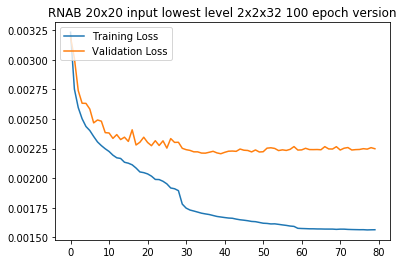

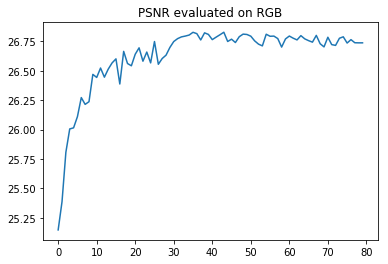

Minimum Training Loss: 0.0015639750020911153
Minimum Validation Loss: 0.002206966979429126
Max PSNR 26.82830109092573
MAX PSNR INDEX 43


In [54]:
################################################ [TODO] ###################################################
# Specify number of epochs, image scale factor, batch size and learning rate
epochs = 80
# i.e, 4
batch_size = 50 # i.e, 16
lr = 0.01        # i.e, 0.01
#lr_lambda = lambda epoch: 0.95 ** epoch
N_train = len(train_dataset)
model_save_path = './model3/'  # directory to same the model after each epoch. 


################################################ [TODO] ###################################################
# Define an optimizer for your model.
# Pytorch has built-in package called optim. Most commonly used methods are already supported.
# Here we use stochastic gradient descent to optimize
# For usage of SGD, you can read https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html
# Also you can use ADAM as the optimizer
# For usage of ADAM, you can read https://www.programcreek.com/python/example/92667/torch.optim.Adam
#0.00001
optimizer = optim.Adam(net.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.SGD(net.parameters(), lr, momentum=0.95, weight_decay=0.001, nesterov=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1) #Step Scheduler. 

TrainingLossData = np.zeros(epochs)
ValidationLossData = np.zeros(epochs)
PSNR_Data = np.zeros(epochs)
# The loss function we use is binary cross entropy: nn.BCELoss()
criterion = nn.MSELoss()
#criterion = gradLoss()
# note that although we want to use DICE for evaluation, we use BCELoss for training in this example
trainF= open("./model4/TrainingEpoch.txt","w+")
validF= open("./model4/ValidationEpoch.txt","w+")
psnrF= open("./model4/PSNR_Epoch.txt","w+")

################################################ [TODO] ###################################################
# Start training
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    scheduler.step()
    net.train()
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    epoch_loss = 0
    for i, b in enumerate(train_loader):
        ################################################ [TODO] ###################################################
        # Get images and masks from each batch
        imgs = b['img'].to(deviceTag);
        label = b['label'].to(deviceTag);
        imgs = imgs.type(torch.FloatTensor);
        label = label.type(torch.FloatTensor).to(deviceTag);
        ################################################ [TODO] ###################################################
        # Feed your images into the network
        img_pred16, img_pred20 = net.forward(imgs)
        # Flatten the predicted masks and true masks. For example, A_flat = A.view(-1)
        ################################################ [TODO] ###################################################
        # Calculate the loss by comparing the predicted masks vector and true masks vector
        # And sum the losses together 
        #loss = grad_loss(img_pred, label, epoch)
        #loss = criterion(img_pred_flat, label_flat)
        loss = criterion(img_pred20, label)
        epoch_loss += loss.item()
        if i%100 == 0:
            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item()))
        # optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. 
        # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
        optimizer.zero_grad()
        # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. 
        # These are accumulated into x.grad for every parameter x
        # x.grad += dloss/dx
        loss.backward()
        # optimizer.step updates the value of x using the gradient x.grad. 
        # x += -lr * x.grad
        optimizer.step()
    
    print('Epoch finished ! Loss: {}'.format(epoch_loss / i))
    trainF.write('Epoch finished ! Loss: {}\r\n'.format(epoch_loss / i))
    TrainingLossData[epoch] = epoch_loss / i ## Save for plotting
    ################################################ [TODO] ###################################################
    # Perform validation with eval_net() on the validation data
    val_dice, PSNR = eval_net(net, val_loader)
    ValidationLossData[epoch] = val_dice ## Save for Plotting
    PSNR_Data[epoch] = PSNR ## Save for Plotting
    print('Validation Dice Coeff: {}'.format(val_dice))
    print('PSNR Coeff: {}'.format(PSNR))
    validF.write('Validation Dice Coeff: {}\r\n'.format(val_dice))
    psnrF.write('PSNR Coeff: {}\r\n'.format(PSNR))
    # Save the model after each epoch
    if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Car_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Car_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))
trainF.close()
validF.close()
psnrF.close()

##PLOT DATA
x = range(epochs)
plt.plot(x, TrainingLossData)
plt.plot(x, ValidationLossData)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.title('RNAB 20x20 input lowest level 2x2x32 100 epoch version')
plt.savefig('Train_vali_loss.png')
plt.show()
plt.figure()
plt.plot(x, PSNR_Data)
plt.title('PSNR evaluated on RGB')
plt.savefig('VALI PSNR.png')
plt.show()
print('Minimum Training Loss:', min(TrainingLossData))
print('Minimum Validation Loss:',min(ValidationLossData))
print('Max PSNR',max(PSNR_Data))
print('MAX PSNR INDEX',np.argmax(PSNR_Data))

In [34]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=50, shuffle=True, num_workers=2)
val_dice, PSNR = eval_net(net, val_loader)
print(PSNR)

25.09502997433888


In [38]:
trainF.close()
validF.close()
psnrF.close()

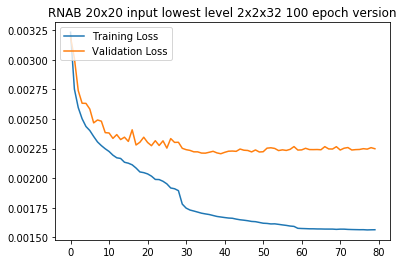

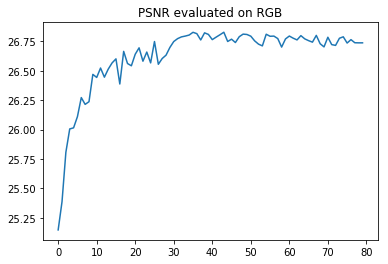

Minimum Training Loss: 0.0015639750020911153
Minimum Validation Loss: 0.002206966979429126
Max PSNR 26.82830109092573
MAX PSNR INDEX 43


In [55]:
x = range(epochs)
plt.plot(x, TrainingLossData)
plt.plot(x, ValidationLossData)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.title('RNAB 20x20 input lowest level 2x2x32 100 epoch version')
plt.savefig('Train_vali_loss.png')
plt.show()
plt.figure()
plt.plot(x, PSNR_Data)
plt.title('PSNR evaluated on RGB')
plt.savefig('VALI PSNR.png')
plt.show()
print('Minimum Training Loss:', min(TrainingLossData))
print('Minimum Validation Loss:',min(ValidationLossData))
print('Max PSNR',max(PSNR_Data))
print('MAX PSNR INDEX',np.argmax(PSNR_Data))

In [51]:
# Loading parameters Check network is correct
PATH = './model3/2x2x16_combined.pth' #Using grad2
#PATH = './model/Car_Seg_Epoch63.pth'
net = UNet1(3).to(deviceTag);
net.load_state_dict(torch.load(PATH,deviceTag))
net.eval()

RuntimeError: Error(s) in loading state_dict for UNet1:
	Missing key(s) in state_dict: "inc.conv.0.weight", "inc.conv.0.bias", "inc.conv.0.running_mean", "inc.conv.0.running_var", "inc.conv.1.weight", "inc.conv.1.bias", "inc4.0.weight", "inc4.0.bias", "RB1.conv.1.weight", "RB1.conv.1.bias", "RB1.conv2.1.weight", "RB1.conv2.1.bias", "RB2.conv.1.weight", "RB2.conv.1.bias", "RB2.conv2.1.weight", "RB2.conv2.1.bias", "RB3.conv.1.weight", "RB3.conv.1.bias", "RB3.conv2.1.weight", "RB3.conv2.1.bias", "RB4.conv.1.weight", "RB4.conv.1.bias", "RB4.conv2.1.weight", "RB4.conv2.1.bias", "RB5.conv.1.weight", "RB5.conv.1.bias", "RB5.conv2.1.weight", "RB5.conv2.1.bias", "RB6.conv.1.weight", "RB6.conv.1.bias", "RB6.conv2.1.weight", "RB6.conv2.1.bias", "RB7.conv.1.weight", "RB7.conv.1.bias", "RB7.conv2.1.weight", "RB7.conv2.1.bias", "RB8.conv.1.weight", "RB8.conv.1.bias", "RB8.conv2.1.weight", "RB8.conv2.1.bias", "RB9.conv.1.weight", "RB9.conv.1.bias", "RB9.conv2.1.weight", "RB9.conv2.1.bias". 
	Unexpected key(s) in state_dict: "inc.0.weight", "inc.0.bias", "inc4.1.weight", "inc4.1.bias". 

### [ TODO 4 ] load one image from testing dataset and plot output mask

In [60]:
################################################ [TODO] ###################################################
# Define a function for prediction/testing
def predict_img(net,full_img):
    # set the mode of your network to evaluation
    net.eval()
    # convert from Height*Width*Channel TO Channel*Height*Width
    # convert numpy array to torch tensor 
    #Unsqueeze add an extra dimension
    X_img = torch.from_numpy(full_img).unsqueeze(0)
    X_img = X_img.type(torch.FloatTensor).to(deviceTag)
    with torch.no_grad():
        ################################################ [TODO] ###################################################
        # predict the masks 
        output_img16,output_img = net.forward(X_img)
        output_img = output_img.squeeze(0)
        output_img16 = output_img16.squeeze(0)
        X_img = X_img.squeeze(0)
        error = F.mse_loss(output_img, X_img)
        #error = 1
    return output_img, error


In [61]:
# You might need to use these functions in the following steps
# hwc_to_chw: Convert images from Height*Width*Channels to Channels*Height*Width
def hwc_to_chw(img):
    return np.transpose(img, axes=[2, 0, 1])

### Plot original image and mask image

# Train Image Example

In [62]:
def DisplayImage(test_img,pred_img,error):
    test_img_show = np.transpose(test_img, axes=[1, 2, 0]) + 128/255
    test_img_show=test_img_show.astype(np.float32)
    #test_img_show = cv2.cvtColor(test_img_show, cv2.COLOR_YCR_CB2BGR)
    #test_img_show = cv2.cvtColor(test_img_show, cv2.COLOR_BGR2RGB)
    plt.imshow(test_img_show)
    plt.title('16x16 input')
    fig = plt.figure()
    fig.text(.5, .01, str(error), ha='center')
    plt.title('16x16 pred')
    pred_img_show = np.transpose(pred_img, axes=[1, 2, 0]) +128/255
    plt.imshow(pred_img_show)
    plt.figure()

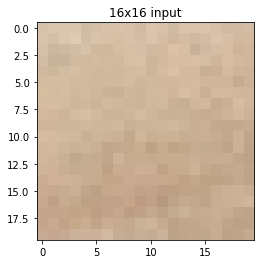

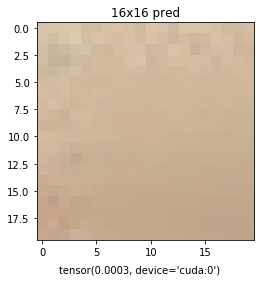

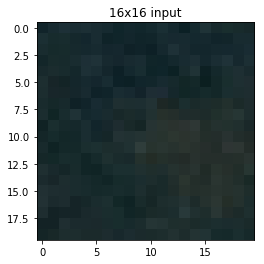

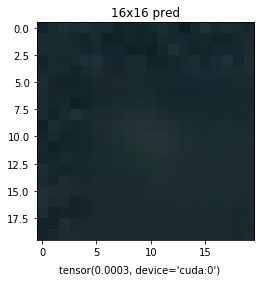

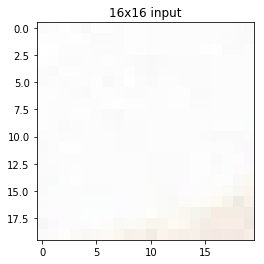

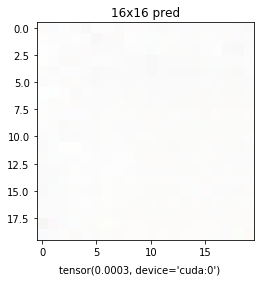

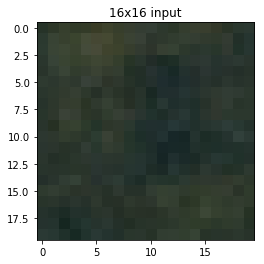

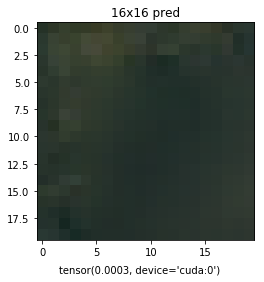

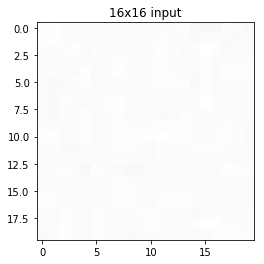

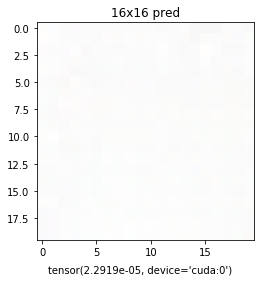

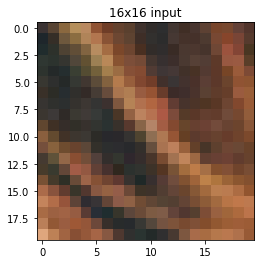

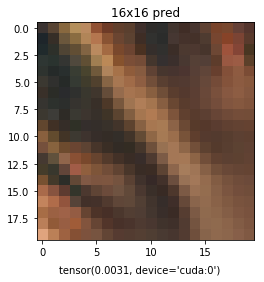

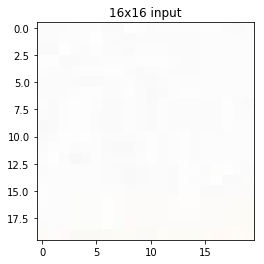

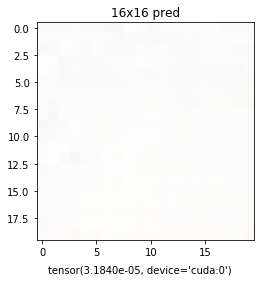

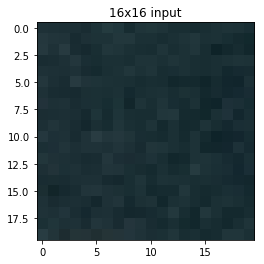

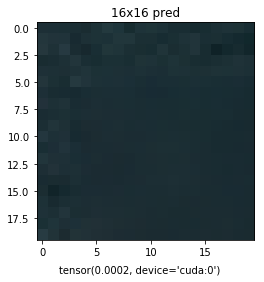

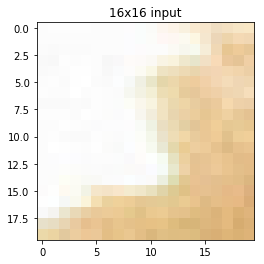

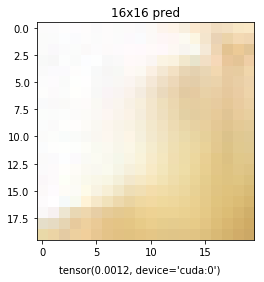

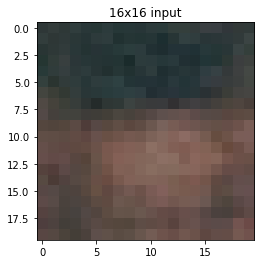

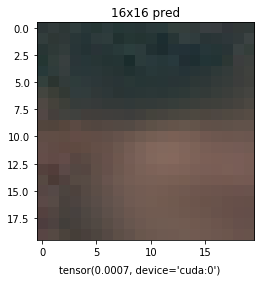

<Figure size 432x288 with 0 Axes>

In [63]:
# Plot original images and masks
count = 0;
for i in range(50,100):
    imgnum = i*57
    #test_img = (trainDataset[1][imgnum] - 128)/255
    test_img = trainDataset[0][imgnum]
    lx = np.gradient(test_img, axis=0)
    ly = np.gradient(test_img, axis=1)
    t = 1
    #t=np.sum(lx**2+ly**2)/(16*16)
    #print(t)
    if t>0.01:
        pred_img,error = predict_img(net, test_img)
        pred_img = pred_img.cpu()
        DisplayImage(test_img,pred_img,error)
        count= count+1
    if count == 10:
        break

# Validation Image Example

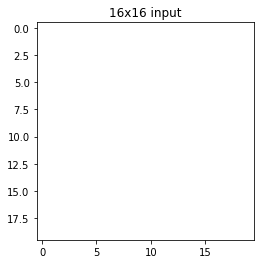

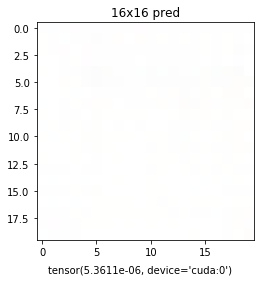

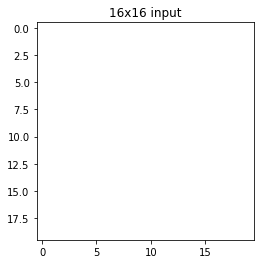

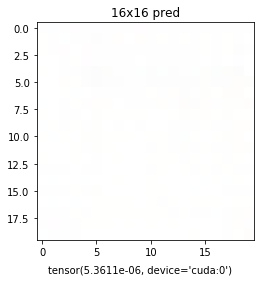

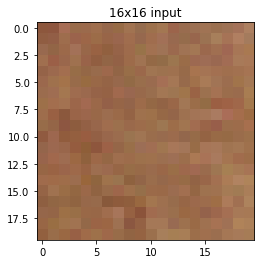

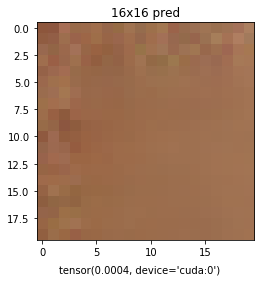

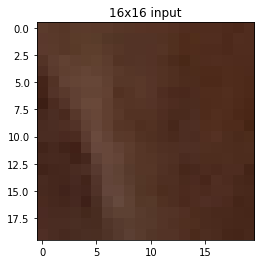

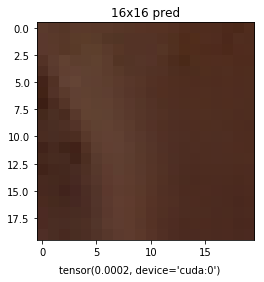

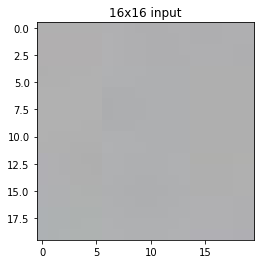

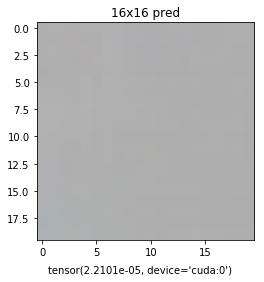

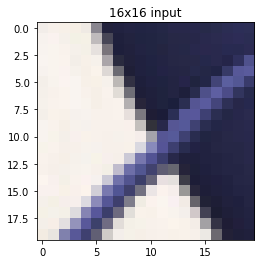

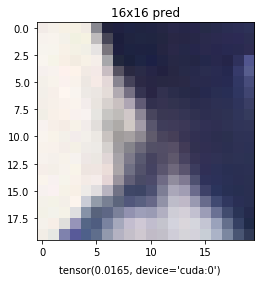

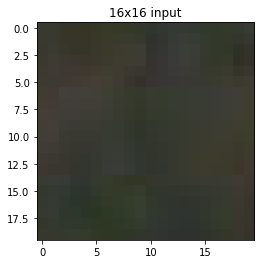

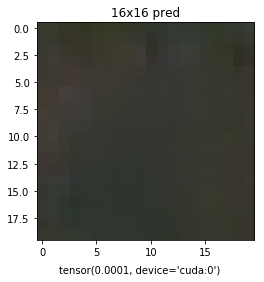

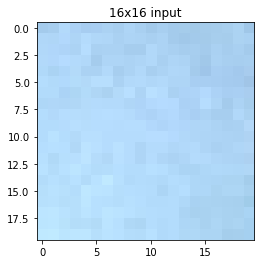

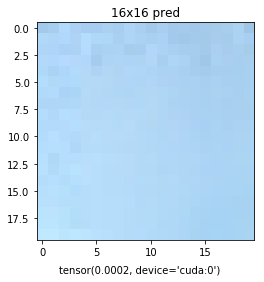

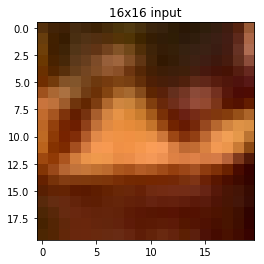

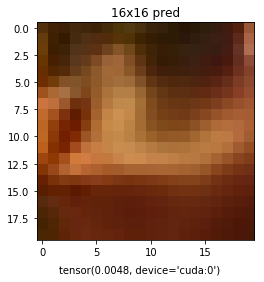

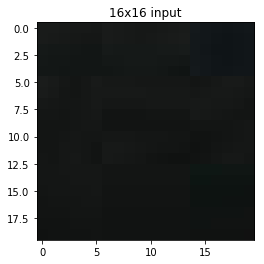

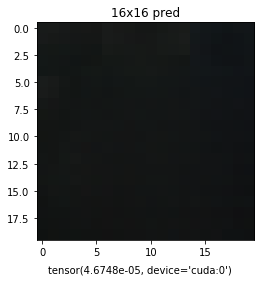

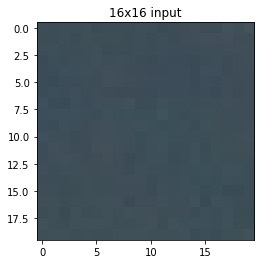

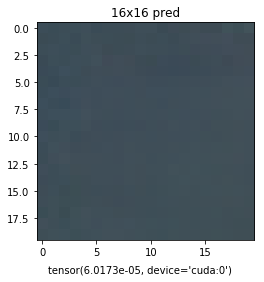

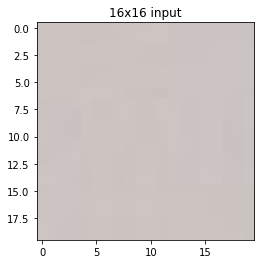

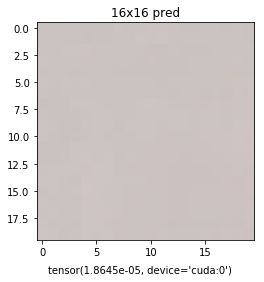

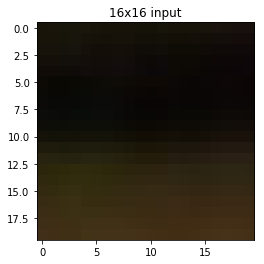

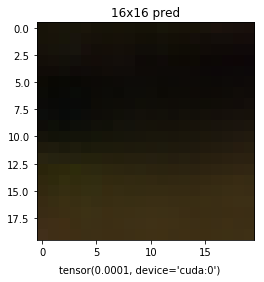

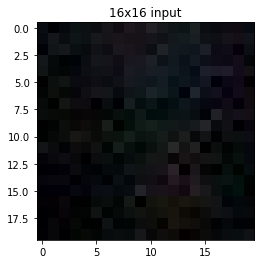

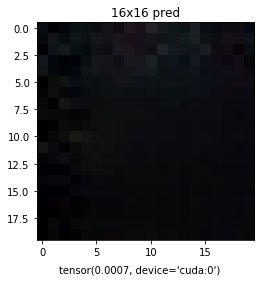

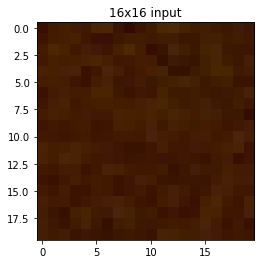

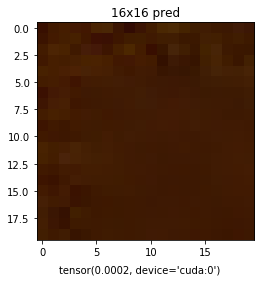

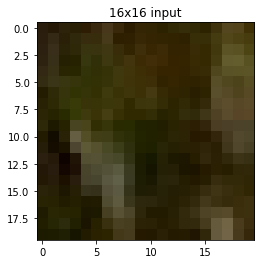

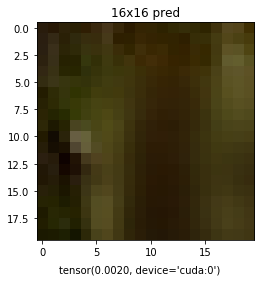

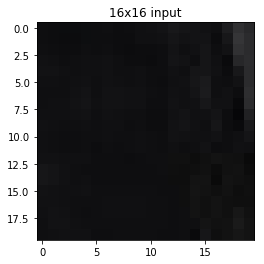

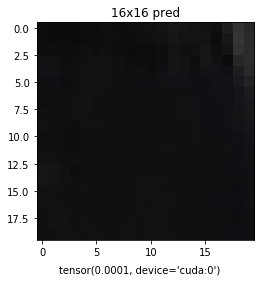

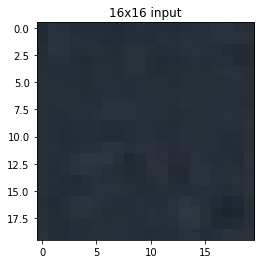

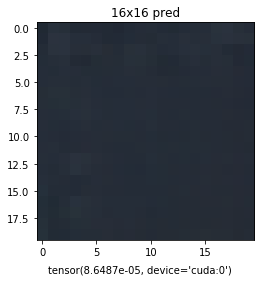

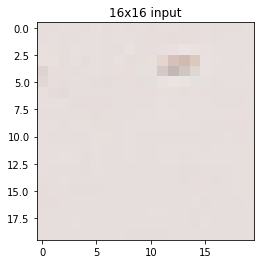

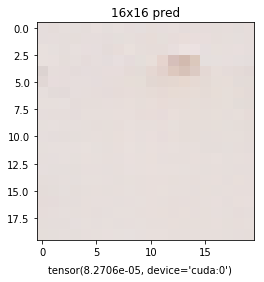

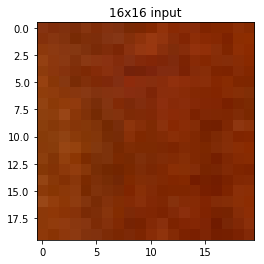

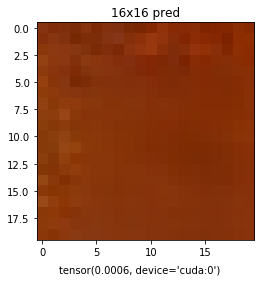

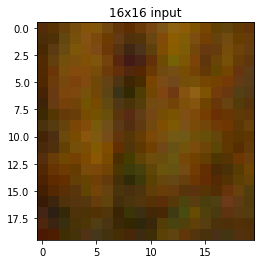

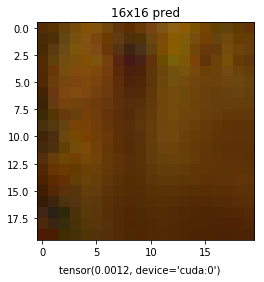

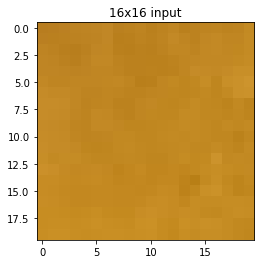

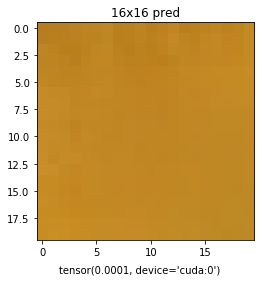

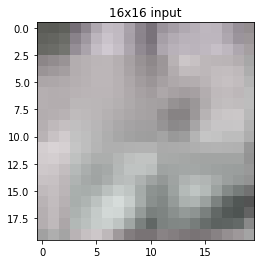

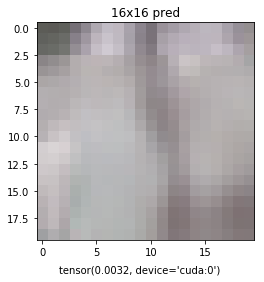

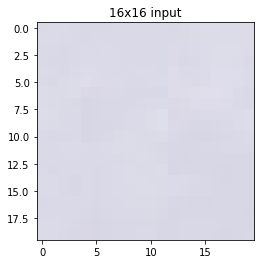

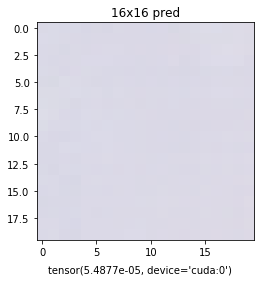

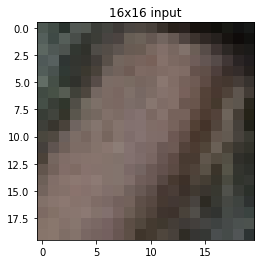

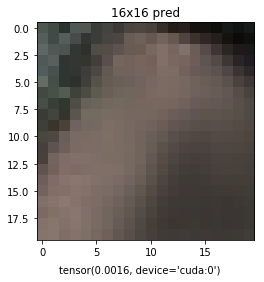

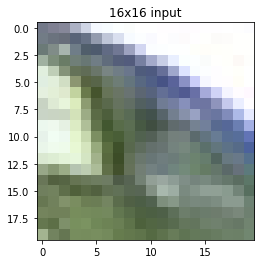

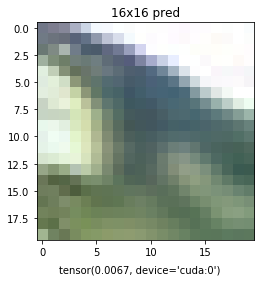

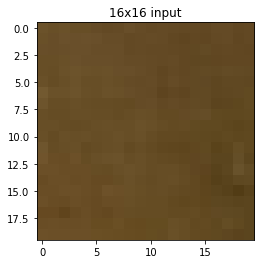

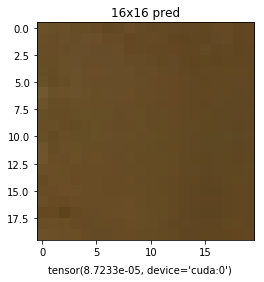

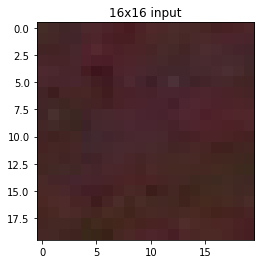

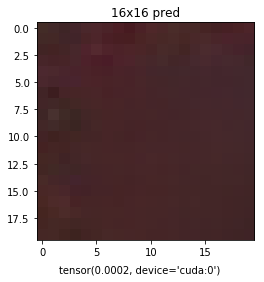

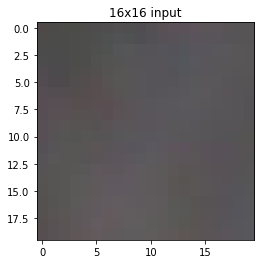

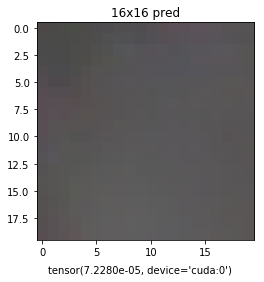

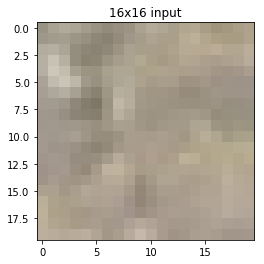

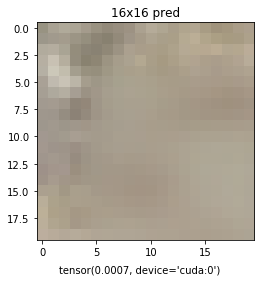

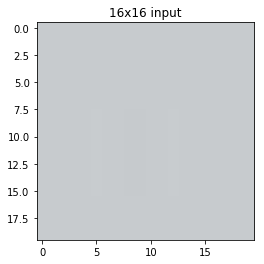

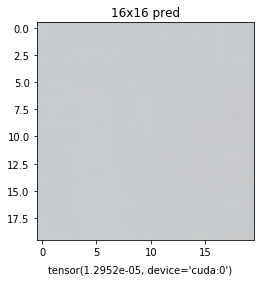

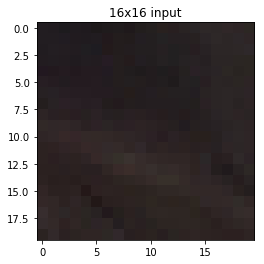

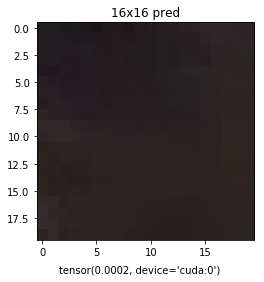

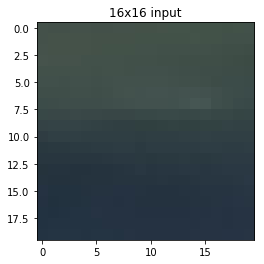

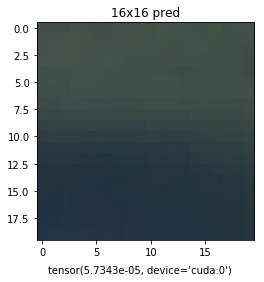

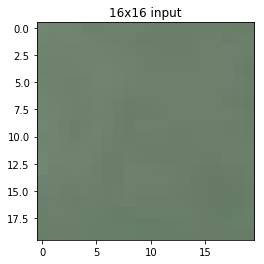

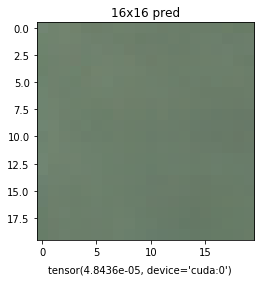

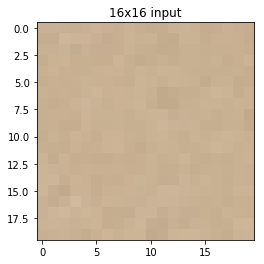

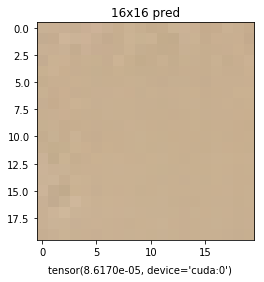

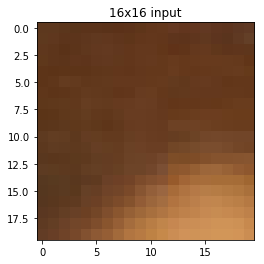

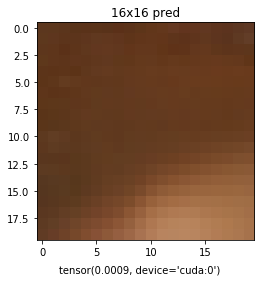

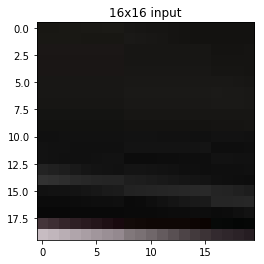

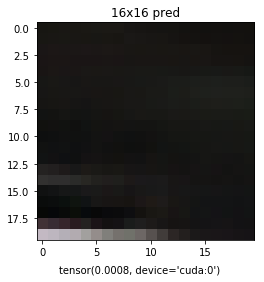

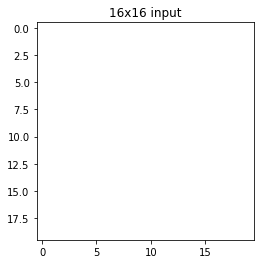

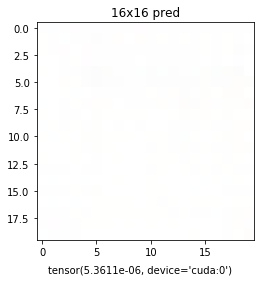

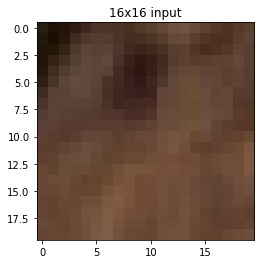

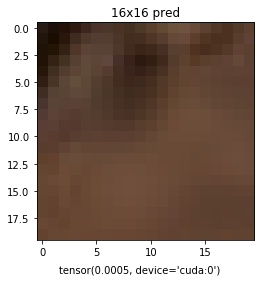

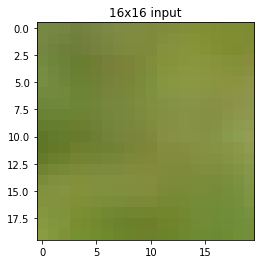

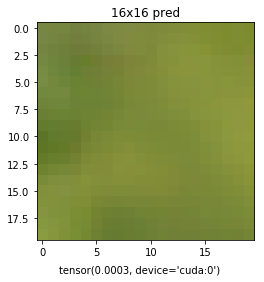

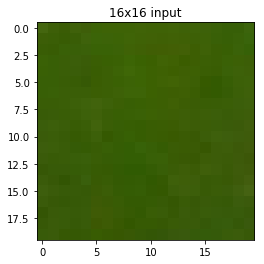

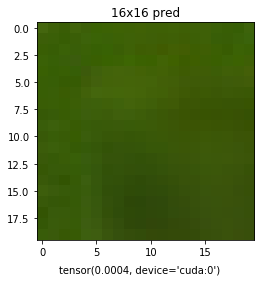

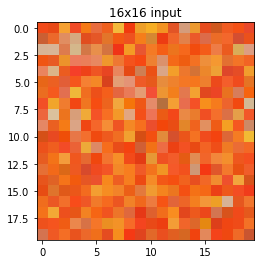

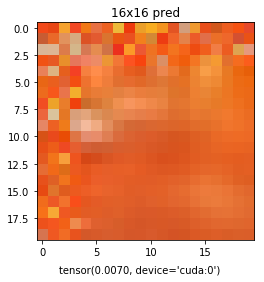

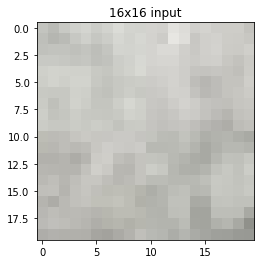

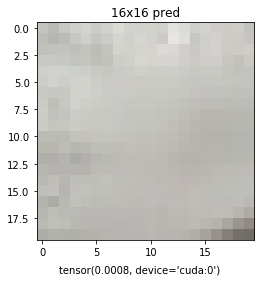

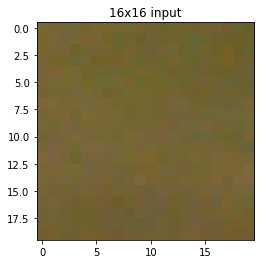

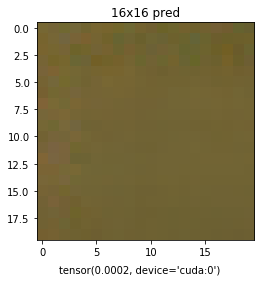

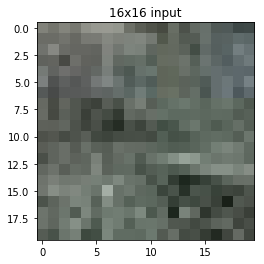

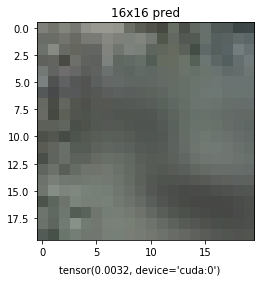

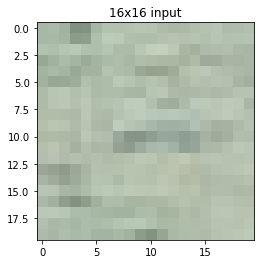

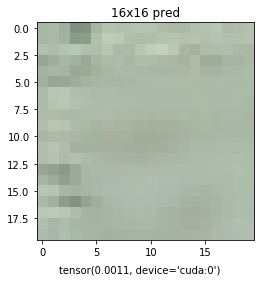

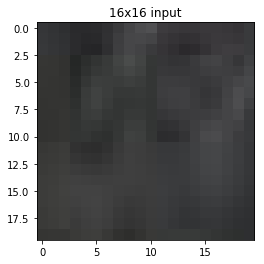

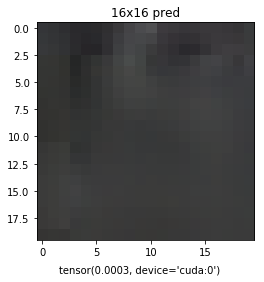

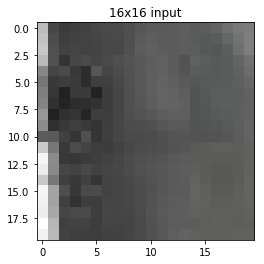

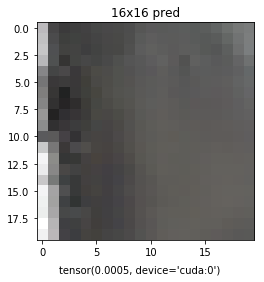

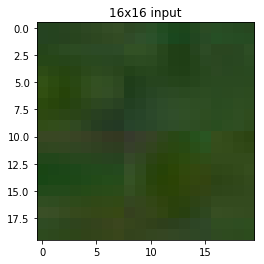

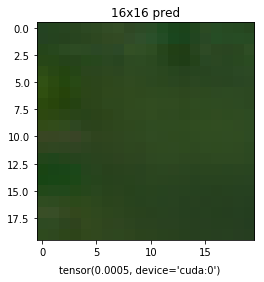

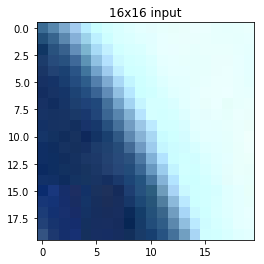

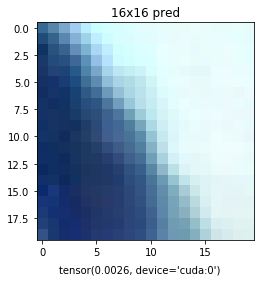

<Figure size 432x288 with 0 Axes>

In [64]:
# Plot original images and masks
count = 0;
for i in range(50,100):
    imgnum = i*57
    #test_img = (trainDataset[1][imgnum] - 128)/255
    test_img = valiDataset[0][imgnum]
    lx = np.gradient(test_img, axis=0)
    ly = np.gradient(test_img, axis=1)
    #t=np.sum(lx**2+ly**2)/(16*16)
    t = 1
    #print(t)
    if t>0.01:
        pred_img, error = predict_img(net, test_img)
        pred_img = pred_img.cpu()
        DisplayImage(test_img,pred_img, error)
    if count == 10:
        break

In [41]:
print(trainDataset[1].shape)

(199913, 3, 16, 16)


# Testing Dataset Example

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


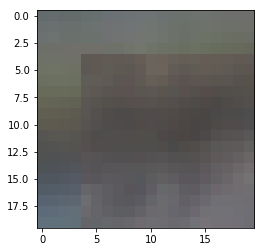

<Figure size 432x288 with 0 Axes>

In [47]:
length = valiDataset[0].shape[0]
net.eval()
for i in range(length):
    small_img = valiDataset[1][i]
    small_img = torch.from_numpy(small_img).unsqueeze(0)
    small_img = small_img.type(torch.FloatTensor).to(deviceTag)
    with torch.no_grad():
        ################################################ [TODO] ###################################################
        # predict the masks 
        filtered_img = net.forward(small_img)
        filtered_img = filtered_img.squeeze(0)
    filtered_img = filtered_img.cpu()
    large_img = valiDataset[0][i] 
    large_img[:,4:20,4:20]= filtered_img
    valiDataset[0][i] = large_img
    if i%1000 == 0:
        print(i)
large_img = np.transpose(valiDataset[0][100],(1,2,0))+0.5
plt.imshow(large_img)
plt.figure()
f1=open('valiFilt20_32','wb')
pickle.dump(valiDataset[0],f1)
f1.close()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


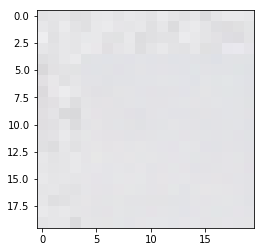

<Figure size 432x288 with 0 Axes>

In [48]:
length = trainDataset[0].shape[0]
net.eval()
for i in range(length):
    small_img = trainDataset[1][i]
    small_img = torch.from_numpy(small_img).unsqueeze(0)
    small_img = small_img.type(torch.FloatTensor).to(deviceTag)
    with torch.no_grad():
        ################################################ [TODO] ###################################################
        # predict the masks 
        filtered_img = net.forward(small_img)
        filtered_img = filtered_img.squeeze(0)
    filtered_img = filtered_img.cpu()
    large_img = trainDataset[0][i] 
    large_img[:,4:20,4:20]= filtered_img
    trainDataset[0][i] = large_img
    if i%1000 == 0:
        print(i)
large_img = np.transpose(trainDataset[0][100],(1,2,0))+0.5
plt.imshow(large_img)
plt.figure()
f1=open('trainFilt20_32','wb')
pickle.dump(trainDataset[0],f1)
f1.close()

In [30]:
f1=open('valiFilt20','wb')
pickle.dump(valiDataset[0],f1)
f1.close()

In [52]:
print(i)

142128


In [ ]:
val_dice = eval_net(net, val_loader)
print('Validation Dice Coeff: {}'.format(val_dice))

In [ ]:
t = tf.constant([[[[1, 2, 3], [4, 5, 6]],[[1, 2, 3], [4, 5, 6]]],
                [[[1, 2, 3], [4, 5, 6]],[[1, 2, 3], [4, 5, 6]]]])
print(t.shape)
paddings = tf.constant([[0, 0,],[0, 0,],[1, 1,], [2, 2]])
p = tf.pad(t, paddings, "SYMMETRIC")
print(p.shape)
print(tf.contrib.framework.is_tensor(p))

In [ ]:
a,b,c = 0.6, 0.4, 0.3


In [ ]:
# Loading parameters
PATH = './model/Car_Seg_Epoch2.pth' #Using grad2
#PATH = './model/Car_Seg_Epoch63.pth'
net = UNet(3).to(deviceTag);
net.load_state_dict(torch.load(PATH,deviceTag))
net.eval()

In [ ]:
a = (1.1 %1)

In [ ]:
print(a)